# Building Demand Method 1 Simplified

#### Brief overview:

The energy demand for each cell is assessed according to the following parameters:
𝐵 Number of buildings
𝑆𝑟𝑒𝑠 Share of res buildings
𝑁 Nb of HH per res buildings
𝑎 Electrified status (probability)
𝐸_𝐻𝐻  Energy consumption per HH
𝑟 Adjustment with RWI

For each cell c, we have 𝐷_𝑐=𝐵_𝑐∗𝑆𝑟𝑒𝑠∗𝑁_𝑐  ∗𝑎_𝑐  ∗𝐸_𝐻𝐻  ∗𝑟_𝑐 

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'EDeMOS':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\EDeMOS


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math
from scipy.optimize import fsolve

# Spatial
import geopandas as gpd
from pyproj import CRS

# Mapping / Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import LogNorm
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors

import importlib
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
import config
importlib.reload(config)

<module 'config' from 'C:\\Users\\amillot\\PycharmProjects\\EDeMOS\\config.py'>

In [5]:
from utils import processing_raster, finalizing_rasters, convert_features_to_geodataframe

In [6]:
from Buildings.data_loader import load_initial_data, extract_raster_data, load_un_stats, load_census_data

In [7]:
import Buildings.residential_hh_analysis
importlib.reload(Buildings.residential_hh_analysis)
from Buildings.residential_hh_analysis import determine_location_status, determine_electrification_status, calculate_household_numbers, estimate_hh_with_access
import Buildings.residential_analysis
importlib.reload(Buildings.residential_analysis)
from Buildings.residential_analysis import calculate_energy_per_hh_method1, calculate_total_residential_electricity

In [134]:
import Buildings.figures_input_data
importlib.reload(Buildings.figures_input_data)
from Buildings.figures_input_data import *
import Buildings.figures_results
importlib.reload(Buildings.figures_results)
from Buildings.figures_results import *

In [9]:
area = config.AREA_OF_INTEREST

## Import data

### Load initial data grid

In [10]:
# Load initial data (grid and administrative boundaries)
regions, admin_gdf, region_gdf, grid = load_initial_data(config)
print(grid.crs)

Loading initial data...
Admin boundaries loaded. Country GDF: (1, 3), Region GDF: (10, 12)
Hexagon grid loaded: (17552, 11)
EPSG:4326


### Extract raster values to hexagons

In [11]:
# Extract raster data
grid = extract_raster_data(grid, config, processing_raster, convert_features_to_geodataframe)
print(grid.crs)

Extracting raster data...
EPSG:4326
2025-06-19 14:40:03.754014
Processed WorldPop Buildings Count.
2025-06-19 14:44:43.196579
Processed WorldPop Urban.
2025-06-19 15:32:03.062470
Processed HREA Lighting.
2025-06-19 15:36:23.545389
Processed RWI.
2025-06-19 15:40:54.281747
Processed Falchetta Tiers (Majority).
2025-06-19 15:45:24.413246
Processed Falchetta Tiers (Mean).
Converting features to GeoDataFrame...
2025-06-19 15:45:26.949016
EPSG:4326
Columns after renaming: Index(['geometry', 'h3_index', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'index',
       'NAME_1', 'id', 'buildingssum', 'locationWP', 'HREA', 'rwi',
       'tiers_falchetta_maj', 'tiers_falchetta_mean'],
      dtype='object')
EPSG:4326
EPSG:4326
EPSG:4326
Finished extracting and processing raster data.
EPSG:4326


### Extract residential and service demand from UN stats

In [12]:
total_residential_elec_GWh, total_services_elec_GWh = load_un_stats(config)

Loading UN energy balance statistics...
Total Residential Energy (UN Stats): 4022 GWh
Total Services Energy (UN Stats): 722 GWh


### Load Census data

In [13]:
data_HH, df_censusdata = load_census_data(config)

Loading census data...
Provincial census data loaded: (11, 11)


## Residential electricity consumption assessment

Plotting buildings map...


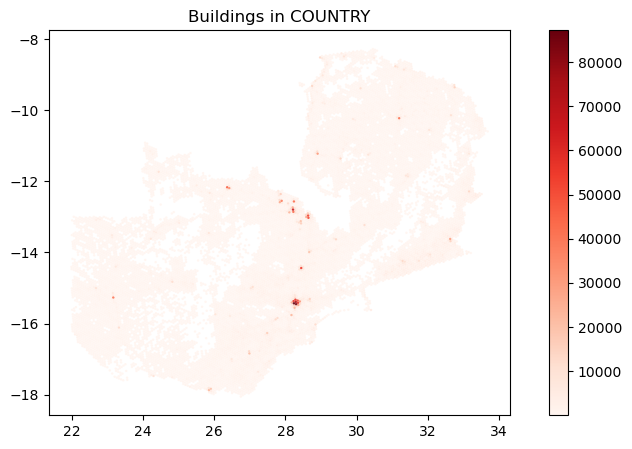

In [14]:
plot_buildings_map(grid, config, fig_size=(10, 5))

In [15]:
print(grid[config.COL_BUILDINGS_SUM].sum())

9186500.0


Plotting HREA map...


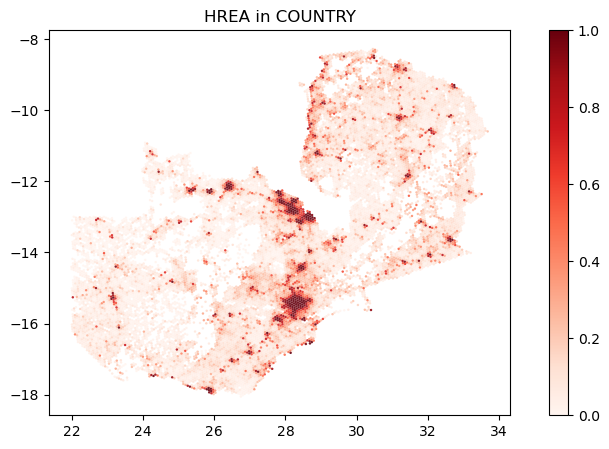

In [16]:
plot_hrea_map(grid, config, fig_size=(10, 5))

### Step 1: assess the number of HH with access

#### Determine location (ruban or rural) of each cell

In [17]:
grid = determine_location_status(grid, config)

Determining location status (urban/rural)...
'location' column created. Counts: {'rural': 17405, 'urban': 147}


Plotting Urban/Rural map...


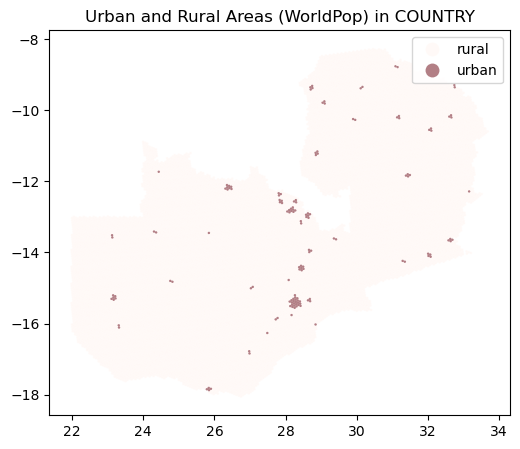

In [18]:
plot_urban_rural_map(grid, config, fig_size=(10, 5))

#### Determine electrifed status of each cell

In [19]:
grid = determine_electrification_status(grid, config, admin_gdf)

Determining electrification status...
--- Initial Data Sanity Check ---
Grid CRS: EPSG:4326 | Shape: (17552, 18)
Admin Boundary CRS: EPSG:4326 | Shape: (1, 3)
MV Lines CRS: EPSG:4326 | Shape: (64868, 49)
HV Lines CRS: EPSG:4326 | Shape: (931, 63)
Target CRS for all operations: EPSG:32735

--- Projecting all data to target CRS ---
Processing proximity for HV Lines with buffer 500m...
Processing proximity for MV Lines with buffer 500m...
Updated 'is_near_any_line' column. Current counts:
is_near_any_line
False    14679
True      2873
Name: count, dtype: int64
'status_electrified' column created. Counts: {'nonelec': 15523, 'elec': 2029}


Plotting Line Proximity map...


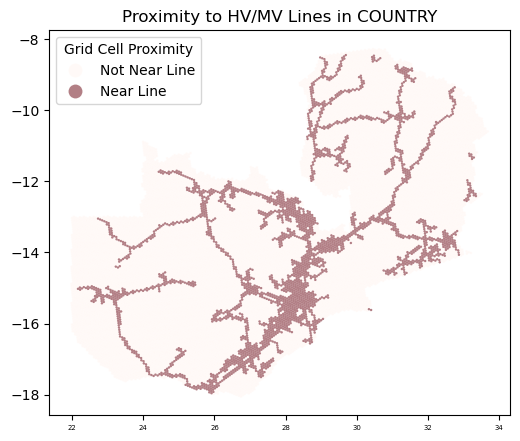

In [37]:
plot_line_proximity_map(grid, config, admin_gdf, fig_size=(10, 5))

#### Assess number of households per cell

In [85]:
grid, df_HH_buildings = calculate_household_numbers(grid, config, data_HH, regions)

Calculating household numbers...
Total population calculated: 17,798,700
Finished calculating household numbers.


In [86]:
df_HH_buildings

,HH_urban,HH_rural,size_HH_urban,size_HH_rural,HH_total,totalBuildings,urbanBuildings,ruralBuildings,shareRuralBuild,shareUrbanBuild,shareUrbanResBui,shareRuralResBui,resUrbanBui,resRuralBui,resTotalBui
region,,,,,,,,,,,,,,,
Copperbelt,449077.00,85356.00,4.66,5.13,534433.00,1040660.00,574556.00,466104.00,0.45,0.55,0.71,0.18,408251.82,85356.00,493607.82
Muchinga,24953.00,151730.00,4.30,4.73,176683.00,573784.00,83532.00,490252.00,0.85,0.15,0.27,0.31,22684.55,151730.00,174414.55
North-Western,91501.00,116233.00,5.03,5.53,207734.00,517799.00,146182.00,371617.00,0.72,0.28,0.57,0.31,83182.73,116233.00,199415.73
Western,54466.00,205604.00,4.47,4.92,260070.00,751165.00,81720.00,669445.00,0.89,0.11,0.61,0.31,49514.55,205604.00,255118.55
Luapula,44689.00,228300.00,4.72,5.19,272989.00,583700.00,82797.00,500903.00,0.86,0.14,0.49,0.46,40626.36,228300.00,268926.36
Northern,72867.00,230684.00,4.58,5.04,303551.00,728186.00,96378.00,631808.00,0.87,0.13,0.69,0.37,66242.73,230684.00,296926.73
Central,98493.00,292947.00,4.75,5.22,391440.00,1293182.00,214889.00,1078293.00,0.83,0.17,0.42,0.27,89539.09,292947.00,382486.09
Southern,120410.00,316294.00,4.66,5.13,436704.00,1303679.00,128001.00,1175678.00,0.90,0.10,0.86,0.27,109463.64,316294.00,425757.64
Eastern,82166.00,369725.00,4.68,5.15,451891.00,1285025.00,118608.00,1166417.00,0.91,0.09,0.63,0.32,74696.36,369725.00,444421.36


#### Assess number of households per cell with access to electricity

In [87]:
grid, df_HH_buildings = estimate_hh_with_access(grid, config, df_HH_buildings, data_HH)

Estimating households with access...
Aggregating HH access data by region...
Total population with access (estimated): 173,667,846
Regional HH summary saved to C:\Users\amillot\PycharmProjects\EDeMOS\Buildings\Outputs\dataHH_region.csv
         accessRateHH accessRateHH_urban accessRateHH_rural
Central          0.31               0.74               0.41
Southern         0.39               0.99               0.54
Eastern          0.23               0.73               0.28
Lusaka           0.90               1.00               5.25
National         0.49               0.92               0.17
Finished estimating households with access.


### Step 2: assess the electricity consumption per HH

#### Method 1: link the energy consumption to rwi through a logistic function

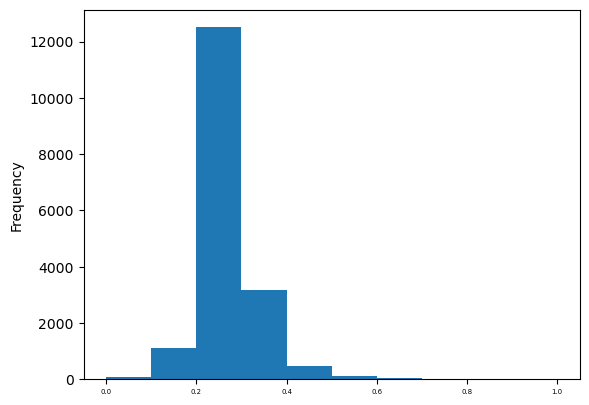

In [88]:
# Normalise the rwi index
rwi_min = grid[config.COL_RWI_MEAN].min()
rwi_max = grid[config.COL_RWI_MEAN].max()
grid[config.COL_RWI_NORM] = (grid[config.COL_RWI_MEAN] - rwi_min) / (rwi_max - rwi_min)
grid[config.COL_RWI_NORM].plot.hist()
plt.show()

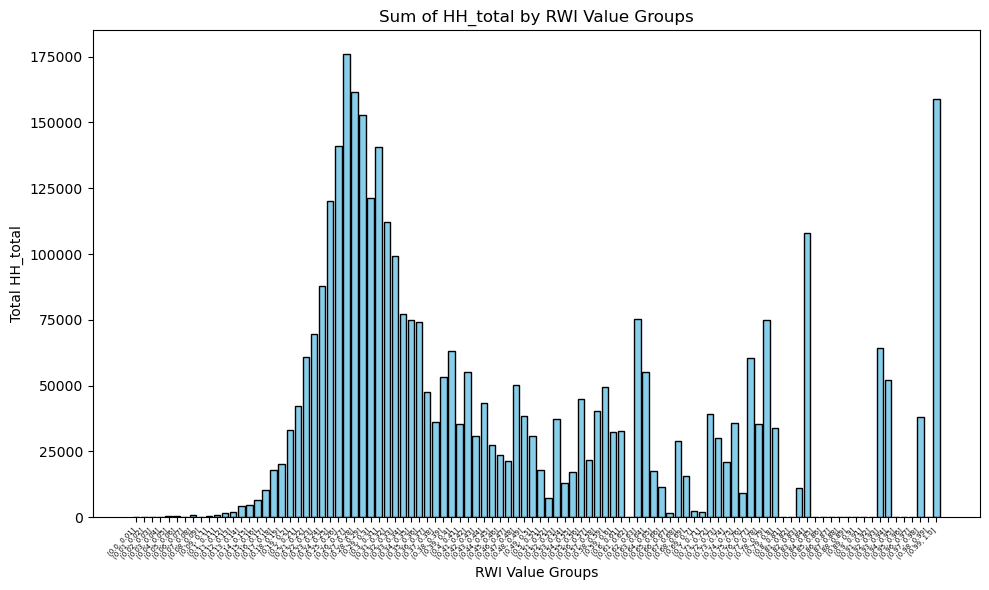

In [89]:
# Plot of number of HH vs rwi

# Create equally spaced bins for the 'rwi' values
num_groups = 100
min_rwi = grid[config.COL_RWI_NORM].min()
max_rwi = grid[config.COL_RWI_NORM].max()
bin_width = (max_rwi - min_rwi) / num_groups
rwi_bins = [min_rwi + i * bin_width for i in range(num_groups + 1)]
rwi_bins_labels = [(rwi_bins[i] + rwi_bins[i])/2 for i in range(num_groups)]

# Group by the bins and sum the 'HH_total' values
grid['rwi_group'] = pd.cut(grid[config.COL_RWI_NORM], rwi_bins)
result = grid.groupby('rwi_group')[config.COL_HH_TOTAL].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
# plt.bar(rwi_bins_labels, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH_total')
plt.title('Sum of HH_total by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

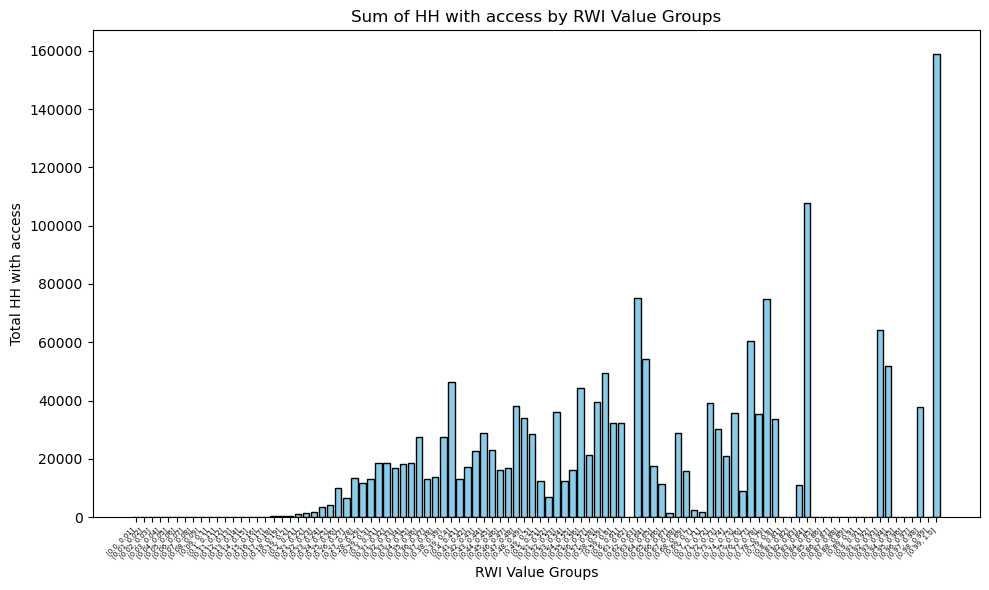

In [90]:
# Plot of number of HH with access vs rwi

# Group by the bins and sum the 'HHwithAccess' values
result = grid.groupby('rwi_group')[config.COL_HH_WITH_ACCESS].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.rc('xtick', labelsize=5)
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH with access')
plt.title('Sum of HH with access by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [91]:
grid, k_to_use = calculate_energy_per_hh_method1(grid, config, total_residential_elec_GWh)

Calculating energy per HH (Method 1: RWI-logistic)...
Solved k for logistic function: 16.2935
Finished calculating energy per HH (Method 1).


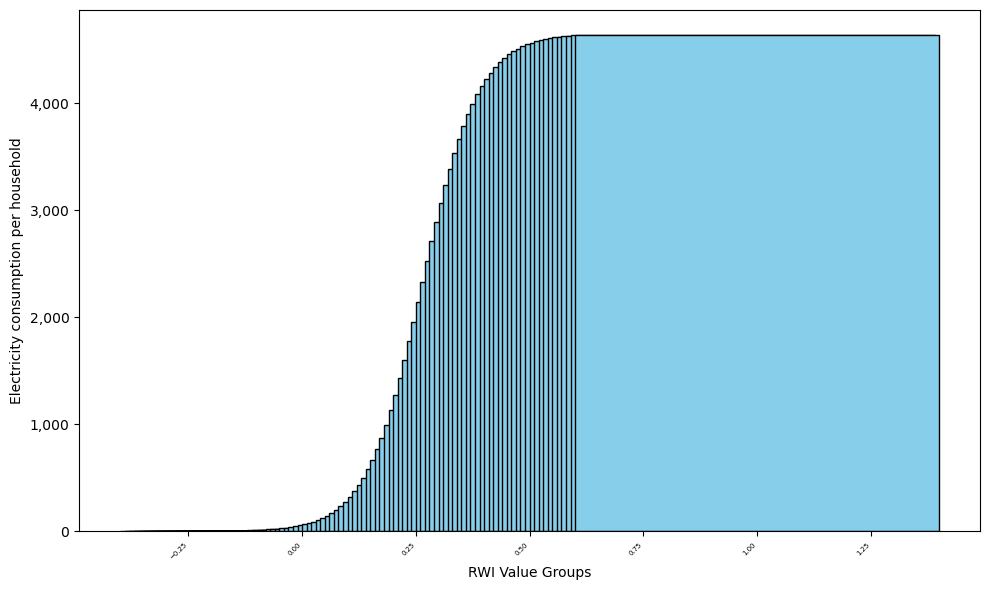

In [92]:
# create the curve linking energy consumption per HH and rwi
rwi_values = rwi_bins # rwi value groups
k = k_to_use  # Adjust this constant for the desired curve steepness
E_threshold = config.LOGISTIC_E_THRESHOLD
alpha = config.LOGISTIC_E_THRESHOLD / config.LOGISTIC_ALPHA_DERIVATION_THRESHOLD - 1
E_HH_values = config.LOGISTIC_E_THRESHOLD / (1 + alpha * np.exp(-k * np.array(rwi_values)))
# print(E_threshold / (1 + alpha * np.exp(-k  * 0)))
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(rwi_values, E_HH_values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Electricity consumption per household')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# plt.title('Energy vs. RWI with logistic relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

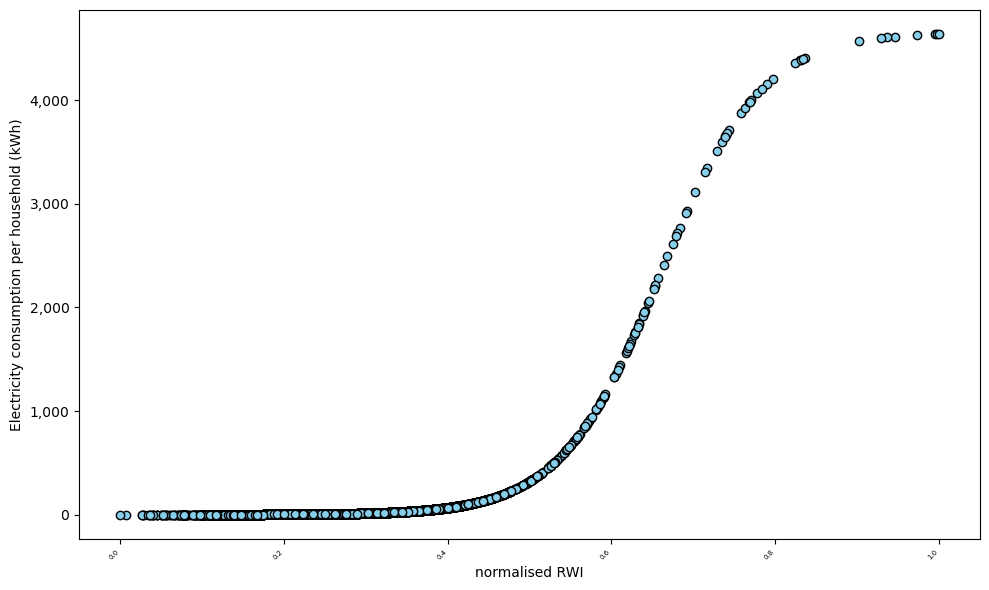

In [93]:
# check that total energy assessed matches the statistics
grid[config.COL_RES_ELEC_PER_HH_LOG] = E_threshold / (1 + alpha * np.exp(-k * grid[config.COL_RWI_NORM]))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.scatter(grid[config.COL_RWI_NORM], grid[config.COL_RES_ELEC_PER_HH_LOG], color='skyblue', edgecolor='black')
plt.xlabel('normalised RWI')
plt.ylabel('Electricity consumption per household (kWh)')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# plt.title('Energy vs. RWI with Logarithmic Relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Method 2: use data coming from the DHS survey

urban total = 2,944 GWh/year
urban average per household = 2,042 kWh/year
urban min = 0 kWh/year max = 2,879 kWh/year
Created rwi_vs_energy_use_urban.png


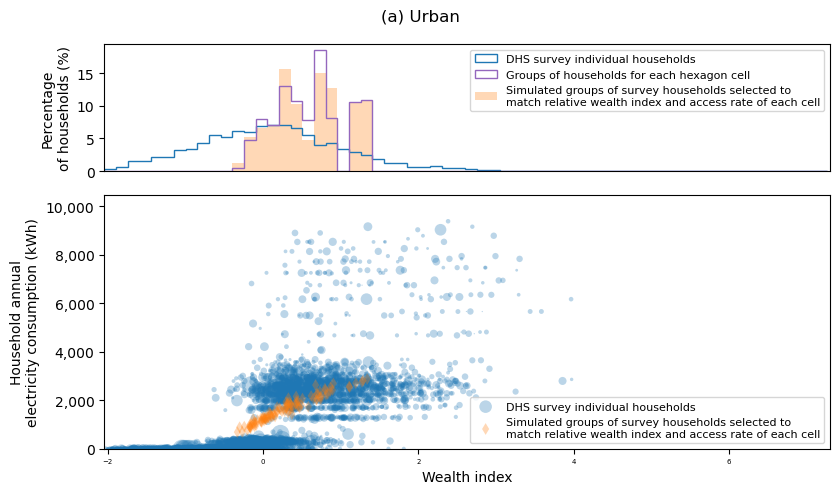

rural total = 27 GWh/year
rural average per household = 74 kWh/year
rural min = 0 kWh/year max = 784 kWh/year
Created rwi_vs_energy_use_rural.png


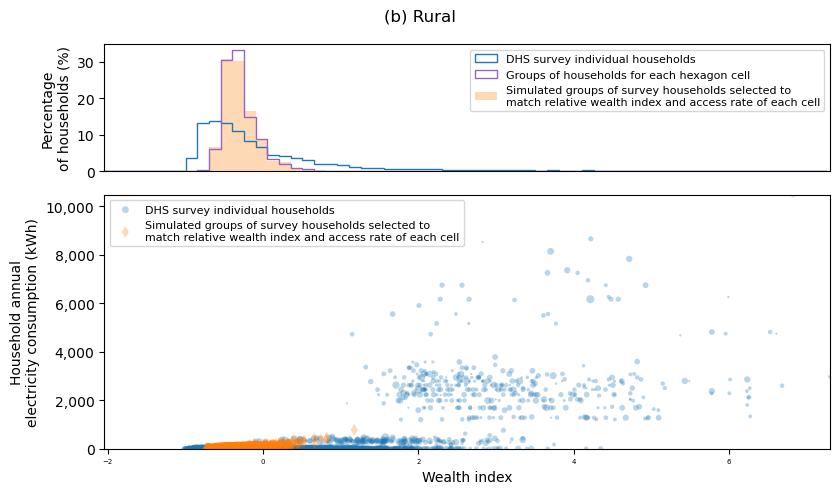

In [94]:
import Buildings.HouseholdEnergyUse.estimate_energy_rwi_link_national_new
# 1. Reload the entire module file
importlib.reload(Buildings.HouseholdEnergyUse.estimate_energy_rwi_link_national_new)
# 2. After reloading, re-import the specific function to get the updated version
from Buildings.HouseholdEnergyUse.estimate_energy_rwi_link_national_new import estimate_energy_rwi_link_national

grid = estimate_energy_rwi_link_national(grid, config)   
col_elec_rural = 'elec_demand_kWh_rural' 
col_elec_urban = 'elec_demand_kWh_urban' 
    
if col_elec_rural not in grid.columns or col_elec_urban not in grid.columns:
    raise KeyError(f"Expected columns '{col_elec_rural}' or '{col_elec_urban}' not found after DHS estimation.")
grid[config.COL_RES_ELEC_PER_HH_DHS] = grid[col_elec_rural] + grid[col_elec_urban]

### Step 3: assess electricity consumption per cell

In [95]:
grid = calculate_total_residential_electricity(grid, config, total_residential_elec_GWh)

Calculating total residential energy and scaling...
Method meth1: Total Assessed = 4022.50 GWh, UN Stats = 4022.50 GWh, Scaling Factor = 1.0000
Method meth2: Total Assessed = 2946.72 GWh, UN Stats = 4022.50 GWh, Scaling Factor = 1.3651

Summary of energy consumption before scaling (GWh):
                meth1   meth2
NAME_1                       
Central        128.91  128.02
Copperbelt    1377.40  953.27
Eastern         43.13   82.86
Luapula         10.78   45.64
Lusaka        2029.70 1256.82
Muchinga         2.52   11.39
North-Western  132.79  120.71
Northern        45.93   78.60
Southern       216.58  203.51
Western         34.77   65.91

Summary of energy consumption after scaling (GWh):
                meth1   meth2
NAME_1                       
Central        128.91  174.76
Copperbelt    1377.40 1301.29
Eastern         43.13  113.11
Luapula         10.78   62.30
Lusaka        2029.70 1715.65
Muchinga         2.52   15.55
North-Western  132.79  164.77
Northern        45.93  107.29

### Compare access rates to Falchetta dataset

In [96]:
def compare_access_to_falchetta(grid_gdf, app_config):
    """
    Compares calculated residential energy consumption tiers with Falchetta dataset tiers.

    This function bins calculated per-household energy into tiers and compares the 
    distribution of households across these tiers against pre-loaded Falchetta tier data.
    It also performs a similarity analysis between the DHS-based calculated tiers and 
    Falchetta's majority tier.

    Args:
        grid_gdf: GeoDataFrame of the hexagonal grid with energy consumption data.
        app_config: The configuration module.

    Returns:
        GeoDataFrame: grid_gdf, potentially with added columns for tiering/comparison.
    """
    print("Comparing access tiers to Falchetta dataset...")

    def calculate_tier_share_method(data_grid, method_suffix, hh_with_access_col, hh_wo_access_col, category_total_val):
        # Helper for tier share calculation
        tier_col_name = f'tiers_{method_suffix}' 
        if tier_col_name not in data_grid.columns:
            # print(f"Warning: Tier column '{tier_col_name}' not found for method '{method_suffix}'.")
            return pd.Series(dtype=float)
        if category_total_val == 0: return pd.Series(dtype=float)

        tier_share = data_grid.groupby(tier_col_name)[hh_with_access_col].sum()
        if 0 in tier_share.index :
            tier_share.loc[0] += data_grid[hh_wo_access_col].sum()
        else: 
            tier_share.loc[0] = data_grid[hh_wo_access_col].sum()
        return tier_share.sort_index() / category_total_val

    bins_tiers = app_config.BINS_TIERS_ENERGY
    tier_labels = range(len(bins_tiers) - 1)

    categories_summary = {
        'national': app_config.COL_HH_TOTAL, 'urban': app_config.COL_HH_URBAN, 'rural': app_config.COL_HH_RURAL
    }

    # Falchetta dataset
    for col_type in [app_config.COL_TIERS_FALCHETTA_MAJ, app_config.COL_TIERS_FALCHETTA_MEAN]:
        if col_type in grid_gdf.columns:
            tiers_summary_df = pd.DataFrame()
            for cat_name, total_hh_col in categories_summary.items():
                 if total_hh_col in grid_gdf.columns and grid_gdf[total_hh_col].sum() > 0:
                    cat_sum = grid_gdf.groupby(col_type)[total_hh_col].sum()
                    tiers_summary_df[cat_name] = cat_sum / cat_sum.sum()
            print(f"\nFalchetta Tiers Summary ({col_type}):")
            print(tiers_summary_df.fillna(0))
    
    # Our methods
    methods_to_compare = {
        'meth1': app_config.COL_RES_ELEC_PER_HH_LOG,
        'meth2': "ElecPerHH_kWh_meth2" 
    }
    categories_for_comparison = [
        ('national', app_config.COL_HH_WITH_ACCESS, app_config.COL_HH_WO_ACCESS, app_config.COL_HH_TOTAL),
        ('urban', app_config.COL_HH_WITH_ACCESS_URB, app_config.COL_HH_WO_ACCESS_URB, app_config.COL_HH_URBAN),
        ('rural', app_config.COL_HH_WITH_ACCESS_RUR, app_config.COL_HH_WO_ACCESS_RUR, app_config.COL_HH_RURAL)
    ]

    for method_key, energy_col_name in methods_to_compare.items():
        if energy_col_name not in grid_gdf.columns:
            print(f"Warning: Energy column '{energy_col_name}' for method '{method_key}' not found.")
            continue
        
        grid_gdf[f'tiers_{method_key}'] = pd.cut(grid_gdf[energy_col_name], bins=bins_tiers, labels=tier_labels, right=False)
        grid_gdf[f'tiers_{method_key}'] = grid_gdf[f'tiers_{method_key}'].fillna(0).astype(int)

        df_tiers_data = pd.DataFrame()
        for cat_name, hh_access_col, hh_no_access_col, total_hh_col in categories_for_comparison:
            if all(c in grid_gdf.columns for c in [hh_access_col, hh_no_access_col, total_hh_col]):
                cat_total_val = grid_gdf[total_hh_col].sum()
                if cat_total_val > 0:
                    tier_share_series = calculate_tier_share_method(grid_gdf, method_key, hh_access_col, hh_no_access_col, cat_total_val)
                    df_tiers_data[cat_name] = tier_share_series
        
        print(f"\nTier Shares for Method '{method_key}':")
        print(df_tiers_data.fillna(0))

    if f'tiers_meth2' in grid_gdf.columns and app_config.COL_TIERS_FALCHETTA_MAJ in grid_gdf.columns:
        grid_gdf['tiers_DHS_adjusted'] = grid_gdf['tiers_meth2'].where(grid_gdf['tiers_meth2'] != 5, 4) 
        grid_gdf['Similarity_Falchetta_DHS'] = grid_gdf['tiers_DHS_adjusted'] == grid_gdf[app_config.COL_TIERS_FALCHETTA_MAJ]
        grid_gdf['Difference_Falchetta_DHS'] = abs(pd.to_numeric(grid_gdf['tiers_DHS_adjusted']) - pd.to_numeric(grid_gdf[app_config.COL_TIERS_FALCHETTA_MAJ]))

        print("\nSimilarity Analysis (Falchetta vs DHS-Method2):")
        print(f"Number of lines with similar tiers: {grid_gdf['Similarity_Falchetta_DHS'].sum()}")
        print(f"Mean difference in tiers: {grid_gdf['Difference_Falchetta_DHS'].mean():.2f}")
        print(f"Median difference in tiers: {grid_gdf['Difference_Falchetta_DHS'].median():.2f}")
    
    print("Finished Falchetta comparison.")
    return grid_gdf

In [97]:
grid = compare_access_to_falchetta(grid, config)

Comparing access tiers to Falchetta dataset...

Falchetta Tiers Summary (tiers_falchetta_maj):
                     national  urban  rural
tiers_falchetta_maj                        
0.00                     0.65   0.20   0.98
1.00                     0.00   0.00   0.00
2.00                     0.01   0.01   0.01
3.00                     0.00   0.00   0.00
4.00                     0.34   0.79   0.01

Falchetta Tiers Summary (tiers_falchetta_mean):
                      national  urban  rural
tiers_falchetta_mean                        
0                         0.53   0.02   0.91
1                         0.07   0.09   0.05
2                         0.08   0.15   0.02
3                         0.07   0.16   0.01
4                         0.25   0.58   0.00

Tier Shares for Method 'meth1':
             national  urban  rural
tiers_meth1                        
0                0.51   0.08   0.84
1                0.07   0.03   0.10
2                0.07   0.10   0.04
3                0.0

### Final grid

In [98]:
# print(grid.columns)
grid.to_csv(config.RESIDENTIAL_GRID_FILE)

In [99]:
# Convert categorical columns to strings
for col in grid.select_dtypes(include=['category']).columns:
    #print(col)
    grid[col] = grid[col].astype(str)

In [100]:
if 'rwi_group' in grid.columns:
    grid = grid.drop('rwi_group', axis=1)
if 'tiers_DHS' in grid.columns:
    grid = grid.drop('tiers_DHS', axis=1)
if 'bin_labels' in grid.columns:
    grid = grid.drop('bin_labels', axis=1)
grid.to_file(config.RESIDENTIAL_OUTPUT_DIR / f'res_energy_map_{config.COUNTRY}.shp', index=False)
grid.head(3)

,geometry,h3_index,n0,n1,n2,n3,n4,n5,index,NAME_1,...,Ser_elec_kWh_bui,nb_women,nb_men,nb_women_working,nb_men_working,total_employee,total_employee_withaccess,ser_elec_kWh_Emp,SElec_kWh_weighted,ser_elec_kWh_final
0,"POLYGON ((30.15835 -11.49771, 30.12117 -11.502...",869611b9fffffff,5433,5705,1736,4522,2006,16376,0,Luapula,...,203.28,6.74,6.13,1.10,1.13,2.23,0.00,0.00,0.00,0.00
1,"POLYGON ((25.80651 -14.77118, 25.76884 -14.775...",86962959fffffff,5100,1836,13758,599,16897,2151,1,Central,...,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
2,"POLYGON ((28.05537 -12.75045, 28.01795 -12.755...",8696014cfffffff,6083,15822,3066,16340,7159,13504,2,Copperbelt,...,128827.64,124.64,113.59,21.81,35.70,57.51,57.51,20461.37,20461.37,20461.37


### Map residential results

Plotting Residential Demand map...


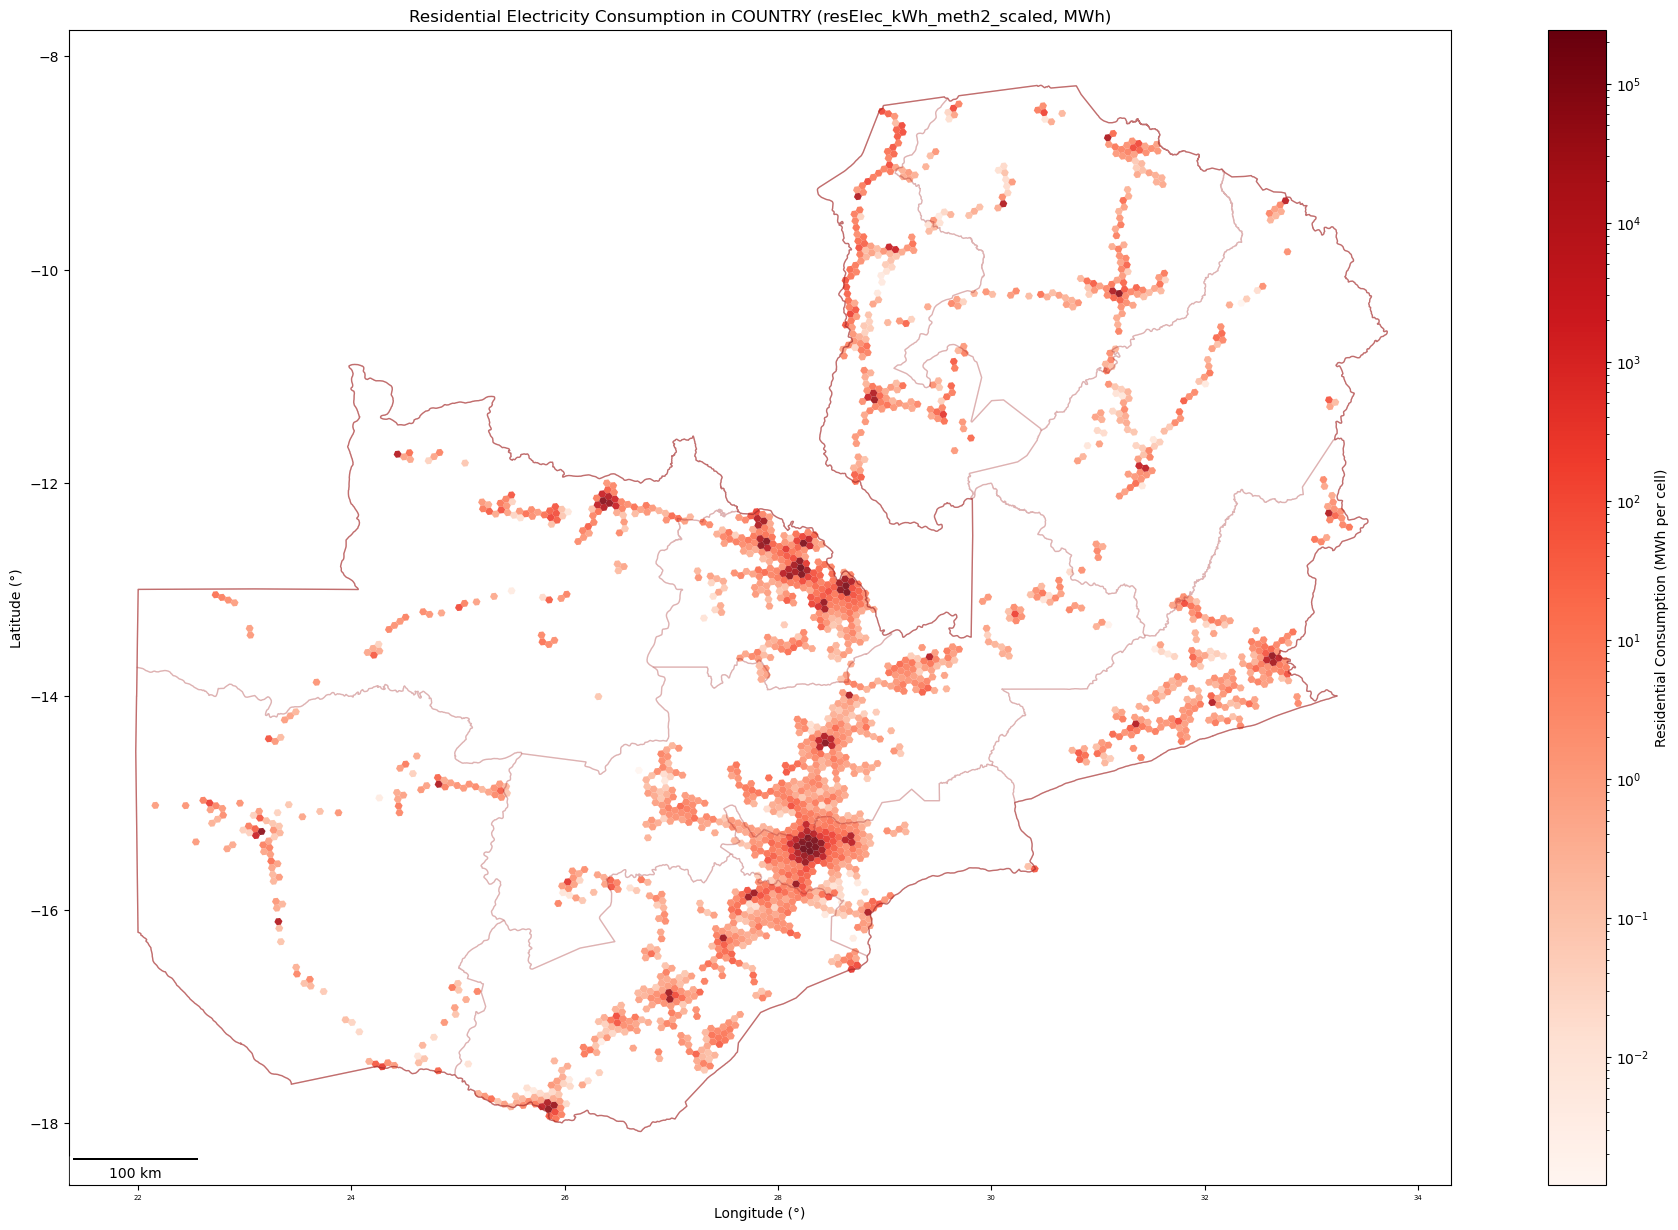

In [110]:
plot_residential_demand_map(grid, config.COL_RES_ELEC_KWH_METH2_SCALED, config, admin_gdf, region_gdf, fig_size=(25, 15))

# Services

In [125]:
import Buildings.service_analysis
importlib.reload(Buildings.service_analysis)
from Buildings.service_analysis import calculate_service_buildings_based_elec, calculate_service_gdp_based_elec, calculate_employee_based_electricity

## Electricity consumption based on number of buildings with access

In [112]:
grid = calculate_service_buildings_based_elec(grid, config, total_services_elec_GWh)

Calculating services electricity (building-based)...
Total services buildings with estimated access: 2,027,615
Service electricity per accessible building: 356 kWh/building
Finished calculating services electricity (building-based).


## Energy consumption based on GDP

In [113]:
# grid = calculate_service_gdp_based_elec(grid, config, total_services_elec_GWh)

## Energy consumption based on employees

In [126]:
grid = calculate_employee_based_electricity(grid, config, total_services_elec_GWh, df_censusdata)

Calculating services energy (employee-based)...
  Calculating number of men and women (15-49)...
  Calculating number of working men and women...
Total employees with access: 2,028,477
Service electricity per accessible employee: 355.77 kWh/employee
Finished calculating services energy (employee-based).


## Weighted average of the three assessements

In [127]:
# if config.COL_GDP_PPP_MEAN in grid.columns:
#     # Link between buildings and GDP
#     plt.scatter(grid['serBUi_Acc'], grid['GDP_PPP'],s=1)
    
#     # Add labels to the plot
#     plt.xlabel('serBUi_Acc')
#     plt.ylabel('GDP_PPP')
    
#     # Set the axis to logarithmic scale
#     # plt.yscale('log')
#     # plt.xscale('log')
    
#     # Show the plot
#     plt.show()

In [128]:
threshold_access = 0.1 # lower value than residential because easier to connect services buildings
alpha = config.SERVICES_WEIGHT_GDP
beta = config.SERVICES_WEIGHT_BUILDINGS
gama = config.SERVICES_WEIGHT_EMPLOYEES

In [129]:
# compute weighted average
# Create a boolean Series indicating if probElec meets the condition
# condition_met = grid[probElec] >= threshold_access
# Assign the weighted average based on the condition
grid['SElec_kWh_weighted'] = (beta * grid[config.COL_SER_ELEC_KWH_BUI] + gama * grid[config.COL_SER_ELEC_KWH_EMP] )

totalSEn_kWh_weighted = grid['SElec_kWh_weighted'].sum()
grid[config.COL_SER_ELEC_KWH_FINAL] = grid['SElec_kWh_weighted'] / totalSEn_kWh_weighted * total_services_elec_GWh *10**6 

## Results per region and map

In [130]:
services_result = pd.DataFrame()
services_result = grid.groupby(config.COL_ADMIN_NAME)[config.COL_SER_ELEC_KWH_FINAL].sum() / 10**6 # conversion in GWh
pd.options.display.float_format = '{:.2f}'.format
services_result

NAME_1
Central          49.11
Copperbelt      195.54
Eastern          46.38
Luapula          28.75
Lusaka          236.10
Muchinga          6.34
North-Western    37.70
Northern         25.10
Southern         72.98
Western          23.68
Name: ser_elec_kWh_final, dtype: float64

Plotting Service Demand map...


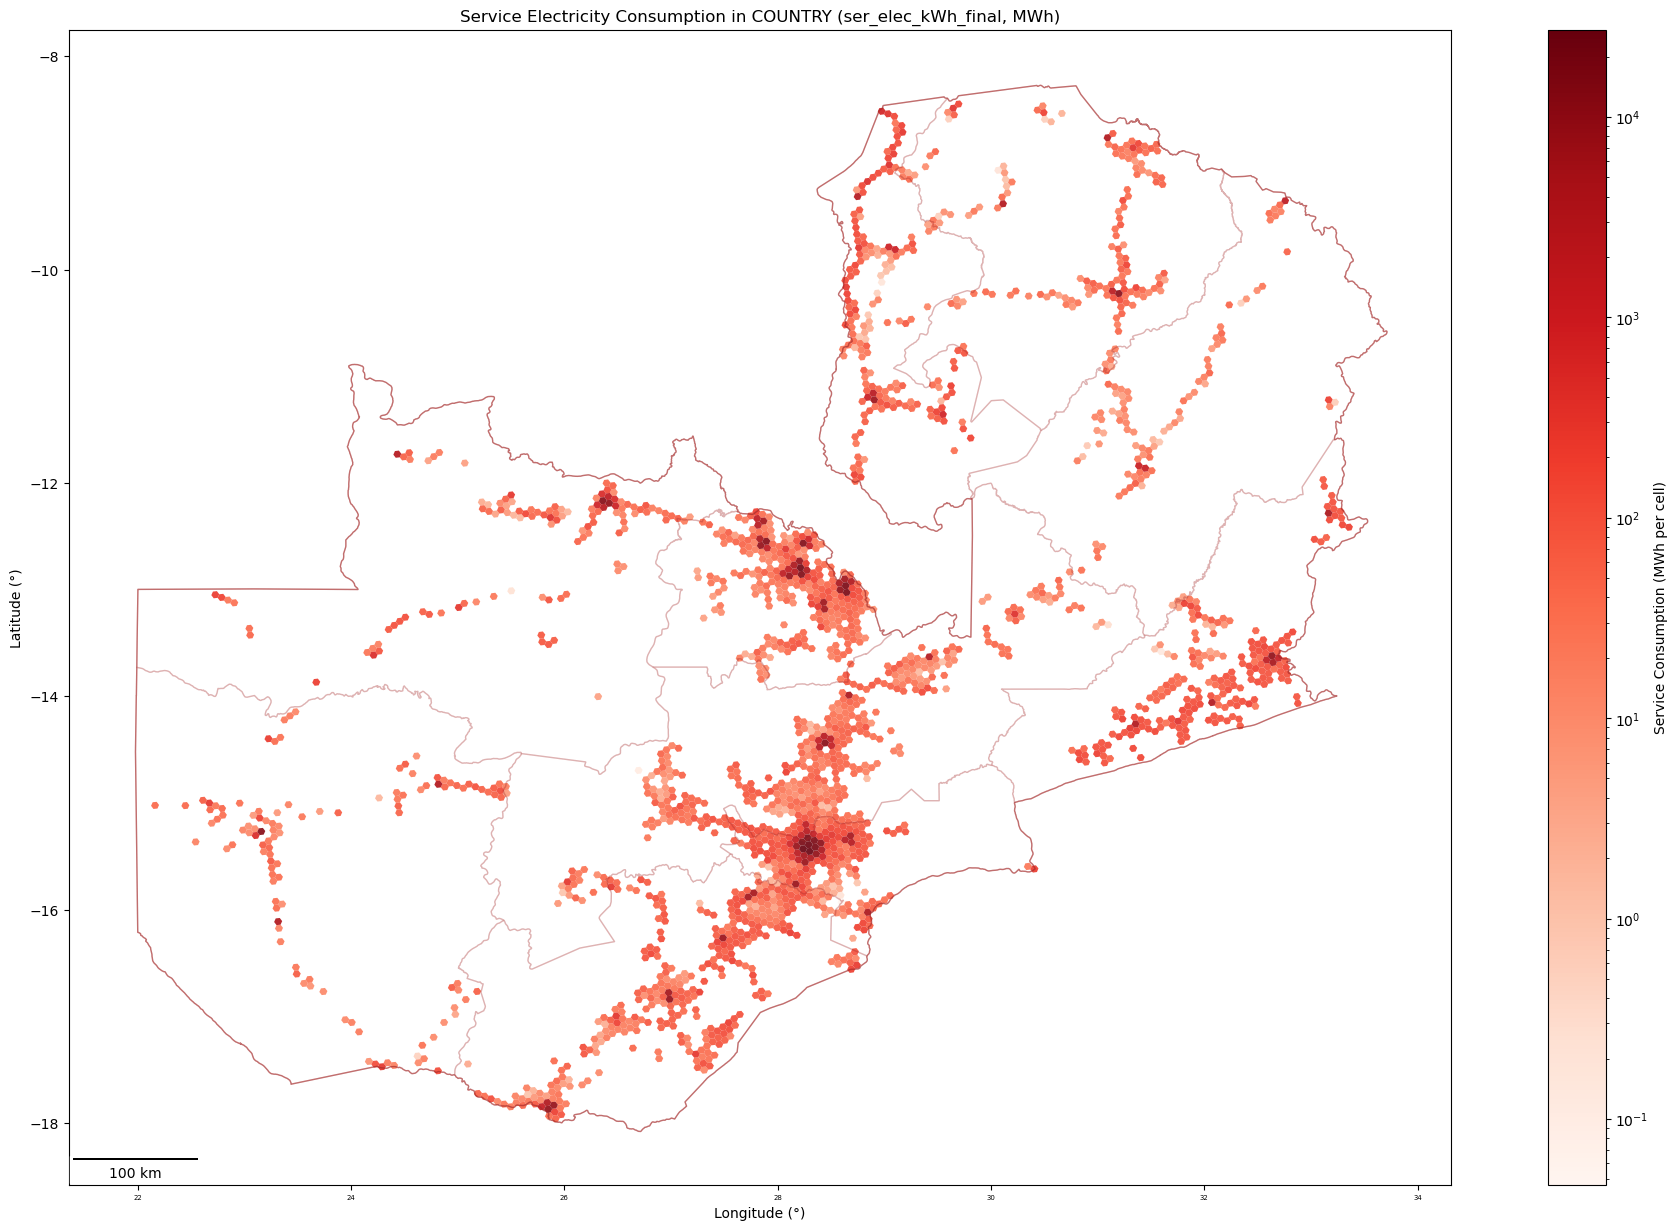

In [135]:
# plot_service_demand_map(grid, config)
plot_service_demand_map(grid, config.COL_SER_ELEC_KWH_FINAL, config, admin_gdf, region_gdf, fig_size=(25, 15))

In [121]:
grid.to_csv(config.SERVICES_GRID_FILE)
# grid.to_file(config.RESIDENTIAL_OUTPUT_DIR / f'ser_energy_map_{config.COUNTRY}.shp', index=False)
# grid.to_file(config.RESIDENTIAL_OUTPUT_DIR /  f'ser_energy_map_{config.COUNTRY}.geojson', driver='GeoJSON', index=False)
grid.to_file(config.BUILDINGS_GPKG_FILE, layer="buildings", driver="GPKG", mode='w')
grid.head(3)

,geometry,h3_index,n0,n1,n2,n3,n4,n5,index,NAME_1,...,Ser_elec_kWh_bui,nb_women,nb_men,nb_women_working,nb_men_working,total_employee,total_employee_withaccess,ser_elec_kWh_Emp,SElec_kWh_weighted,ser_elec_kWh_final
0,"POLYGON ((30.15835 -11.49771, 30.12117 -11.502...",869611b9fffffff,5433,5705,1736,4522,2006,16376,0,Luapula,...,203.28,6.74,6.13,1.10,1.13,2.23,0.00,0.00,0.00,0.00
1,"POLYGON ((25.80651 -14.77118, 25.76884 -14.775...",86962959fffffff,5100,1836,13758,599,16897,2151,1,Central,...,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
2,"POLYGON ((28.05537 -12.75045, 28.01795 -12.755...",8696014cfffffff,6083,15822,3066,16340,7159,13504,2,Copperbelt,...,128827.64,124.64,113.59,21.81,35.70,57.51,57.51,20461.37,20461.37,20461.37


In [122]:
total_services_elec_scaled = grid.groupby(config.COL_ADMIN_NAME)[config.COL_SER_ELEC_KWH_FINAL].sum() 
print ("Services electricity consumption assessed after scaling:")
for region in regions:
    total_services_elec_scaled[region] = total_services_elec_scaled[region]/10**6  # conversion in GWh
    print (region, f"{total_services_elec_scaled[region]:,.1f}", "GWh" )
print (total_services_elec_scaled )
print (total_services_elec_scaled.sum() )

Services electricity consumption assessed after scaling:
Central 49.1 GWh
Copperbelt 195.5 GWh
Eastern 46.4 GWh
Luapula 28.8 GWh
Lusaka 236.1 GWh
Muchinga 6.3 GWh
North-Western 37.7 GWh
Northern 25.1 GWh
Southern 73.0 GWh
Western 23.7 GWh
NAME_1
Central          49.11
Copperbelt      195.54
Eastern          46.38
Luapula          28.75
Lusaka          236.10
Muchinga          6.34
North-Western    37.70
Northern         25.10
Southern         72.98
Western          23.68
Name: ser_elec_kWh_final, dtype: float64
721.6666666666665


In [123]:
total_services_elec_scaled

NAME_1
Central          49.11
Copperbelt      195.54
Eastern          46.38
Luapula          28.75
Lusaka          236.10
Muchinga          6.34
North-Western    37.70
Northern         25.10
Southern         72.98
Western          23.68
Name: ser_elec_kWh_final, dtype: float64

# Buildings

In [124]:
# # total_Buienergy_scaled = total_servicesenergy_scaled + total_residentialenergy_scaled
# total_Buienergy_scaled = total_services_elec_scaled + result_afterscaling['meth2']
# print ("Services electricity consumption assessed after scaling:")
# for region in regions:
#     print (region, f"{total_Buienergy_scaled[region]:,.1f}", "GWh" )
# print (total_Buienergy_scaled)